<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>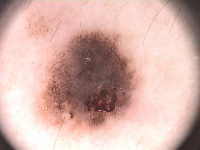</td><td>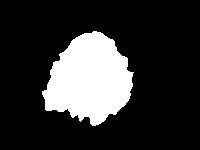</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [11]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=748c8653-bcbf-447e-8a69-ffc03bfa0f57
To: /content/PH2Dataset.rar
100% 162M/162M [00:04<00:00, 39.1MB/s]


In [12]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [13]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [14]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [15]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

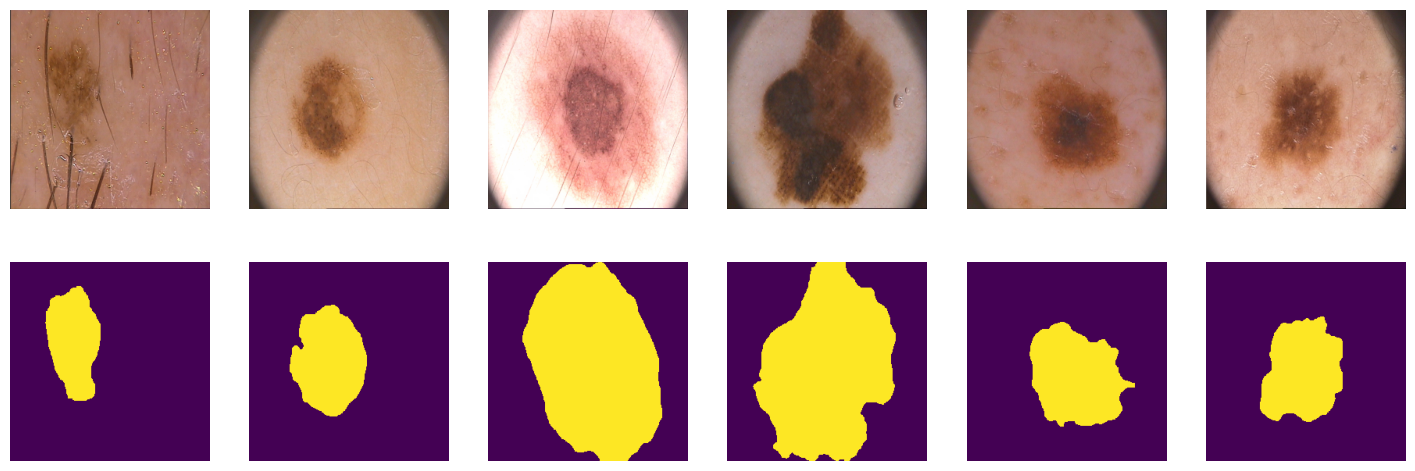

In [16]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [17]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [18]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [19]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [20]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [21]:
!pip install torchmetrics

In [22]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

Рассмотрим выражение под суммой, занесем минус

\begin{align*}
\mathcal{L}_{BCE} &=\sum_i  y\log(1 + e^{-\hat{y}}) + (1-y)\log(1 + e^{\hat{y}}) \\
&= \log(1 + e^{\hat{y}}) + y(\log(1 + e^{-\hat{y}}) - \log(1 + e^{\hat{y}}))
\end{align*}

Упрощение разности логарифмов
\begin{align*}
\log(1 + e^{-\hat{y}}) - \log(1 + e^{\hat{y}}) &= \log\left(\frac{1 + e^{-\hat{y}}}{1 + e^{\hat{y}}}\right) \\
&= \log\left(\frac{e^{-\hat{y}}(e^{\hat{y}} + 1)}{1 + e^{\hat{y}}}\right) \\
&= \log(e^{-\hat{y}}) \\
&= -\hat{y}
\end{align*}

Последнее преобразование (подставили y с шапкой просто вместо скобки, так же выразили из разности логарифмов еще одно выражение)
\begin{align*}
\mathcal{L}_{BCE} &= \sum_i \log(1 + e^{\hat{y}}) - y\hat{y} = \hat{y}- y\hat{y} + \log(1 + e^{-\hat{y}})
\end{align*}
Конец :)



### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [23]:
import torch.nn.functional as F
import torch.nn as nn

In [24]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [25]:
def bce_loss(y_pred, y_real):
  y_pred = torch.sigmoid(y_pred)
  bce_loss_num=-1*torch.sum(y_real*torch.log(y_pred)+(1-y_real)*torch.log(1-y_pred))
  return bce_loss_num

def bce_true(y_pred, y_real):
  bce_true_num=torch.sum(y_pred-y_real*y_pred+torch.log(1+torch.exp(-y_pred)))
  return bce_true_num

Проверим корректность работы на простом примере

In [26]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 4.12691068649292
BCE loss честно посчитанный = 4.126910209655762
BCE loss from torch bce_torch = 4.12691068649292
BCE loss from torch with logits bce_torch = 4.12691068649292


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [27]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [28]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 13.386808395385742
BCE loss честно посчитанный = 13.386808395385742
BCE loss from torch bce_torch = 13.386808395385742
BCE loss from torch with logits bce_torch = 13.386808395385742


In [29]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [30]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 6.99MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 6.73MB/s]
Download completed


In [31]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

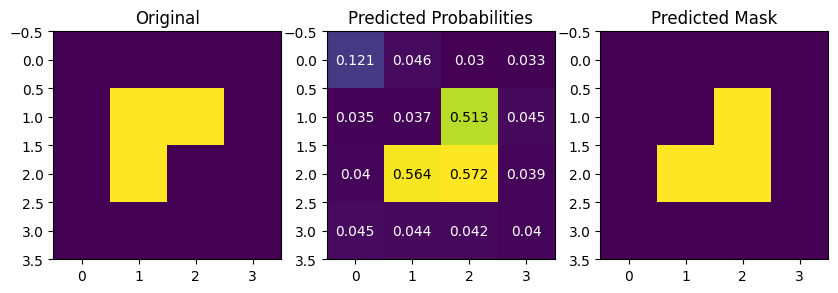

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [33]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

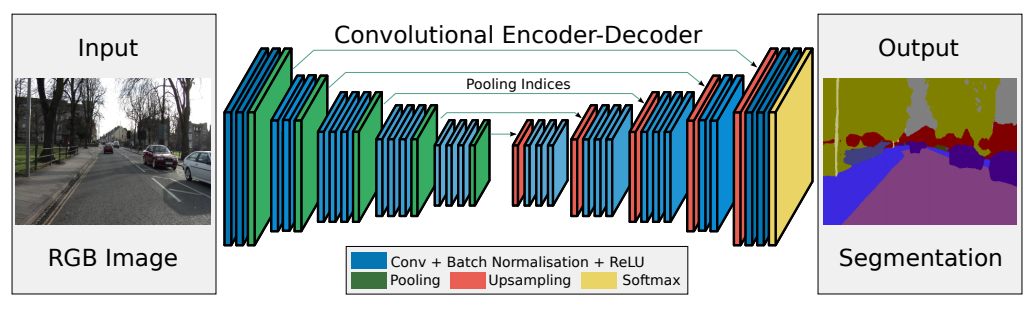

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [41]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()


        self.encoder = nn.ModuleDict({
            "block1": nn.Sequential(
                nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            ),
            "block2": nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True)
            ),
            "block3": nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
            ),
            "block4": nn.Sequential(
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True)
            ),
            "block5": nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True)
            )
        })


        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )


        self.decoder = nn.ModuleDict({
            'block5': nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True)
            ),
            'block4': nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
            ),
            'block3': nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True)
            ),
            'block2': nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            ),
            'block1': nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
            )
        })


        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, 2)

    def forward(self, x):
        pool_ind=[]
        for i in range(1,6):
          x=self.encoder[f"block{i}"](x)
          x,indices=self.pool(x)
          pool_ind.append(indices)

        x=self.bottleneck(x)

        for i in range(5,0,-1):
          x = self.unpool(x, pool_ind[i-1])
          x = self.decoder[f'block{i}'](x)
        return x

In [42]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [43]:
from tqdm.notebook import tqdm

In [44]:
import torch
from tqdm import tqdm
import numpy as np
from torchmetrics import JaccardIndex

def train(model, train_loader, val_loader, criterion, optimizer, device, scheduler=None, save_path="best_model.pth", epochs=10):
    model.to(device)
    best_iou = 0.0
    train_losses = []
    val_losses = []


    jaccard = JaccardIndex(task='binary').to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Valid
        model.eval()
        val_loss = 0.0
        iou_scores = []
        with torch.no_grad():
            val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for images, masks in val_progress:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs) > 0.5
                iou = jaccard(preds, masks)
                iou_scores.append(iou.item())

                val_progress.set_postfix({
                    'val_loss': f'{loss.item():.4f}',
                    'iou': f'{iou.item():.4f}'
                })

        epoch_val_loss = val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        mean_iou = np.mean(iou_scores)

        if scheduler is not None:
            scheduler.step(epoch_val_loss)


        if mean_iou > best_iou:
            best_iou = mean_iou
            torch.save(model.state_dict(), save_path)
            print(f'New best model: {best_iou:.4f}')

    return train_losses, val_losses


Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [45]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(segnet_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
jaccard = JaccardIndex(task='binary').to(device)
train_losses, val_losses = train(
    model=segnet_model,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    save_path="best_segnet.pth",
    epochs=20
)

Epoch 1/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s, val_loss=0.6900, iou=0.0017]


New best model saved with IoU: 0.0017


Epoch 9/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.95it/s, val_loss=0.5659, iou=0.0419]


New best model saved with IoU: 0.0309


Epoch 10/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s, val_loss=0.5323, iou=0.2316]


New best model saved with IoU: 0.2454


Epoch 11/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.90it/s, val_loss=0.4430, iou=0.4309]


New best model saved with IoU: 0.4634


Epoch 12/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.89it/s, val_loss=0.4176, iou=0.6496]


New best model saved with IoU: 0.6072


Epoch 13/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s, val_loss=0.3731, iou=0.7126]


New best model saved with IoU: 0.6997


Epoch 14/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.90it/s, val_loss=0.3602, iou=0.7538]


New best model saved with IoU: 0.7483


Epoch 15/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s, val_loss=0.3560, iou=0.8012]


New best model saved with IoU: 0.7658


Epoch 16/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.90it/s, val_loss=0.3487, iou=0.7834]


New best model saved with IoU: 0.7863


Epoch 17/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s, val_loss=0.3533, iou=0.7707]


New best model saved with IoU: 0.7941


Epoch 18/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s, val_loss=0.3474, iou=0.7973]


New best model saved with IoU: 0.7993


Epoch 19/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s, val_loss=0.3379, iou=0.8130]


New best model saved with IoU: 0.8009


Epoch 20/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s, val_loss=0.3382, iou=0.8148]


New best model saved with IoU: 0.8020


## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [46]:
def test(model, test_loader, criterion, device, save_path=None):

    model.to(device)
    model.eval()

    test_loss = 0.0
    iou_scores = []
    jaccard = JaccardIndex(task='binary').to(device)

    all_images = []
    all_masks = []
    all_preds = []

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='Testing')
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            iou = jaccard(preds, masks)
            iou_scores.append(iou.item())

            if save_path:
                all_images.append(images.cpu())
                all_masks.append(masks.cpu())
                all_preds.append(preds.cpu())

            progress_bar.set_postfix({
                'test_loss': f'{loss.item():.4f}',
                'iou': f'{iou.item():.4f}'
            })

    avg_loss = test_loss / len(test_loader)
    mean_iou = np.mean(iou_scores)

    print(f'\nTest Loss: {avg_loss:.4f} | Test IoU: {mean_iou:.4f}')

    if save_path:
        results = {
            'images': torch.cat(all_images),
            'masks': torch.cat(all_masks),
            'preds': torch.cat(all_preds)
        }
        torch.save(results, save_path)
        print(f'Predictions saved to {save_path}')

    return avg_loss, mean_iou

In [47]:
test_loss, test_iou = test(
    model=segnet_model,
    test_loader=test_dataloader,
    criterion=nn.BCEWithLogitsLoss(),
    device=device,
    save_path='test_predictions.pt'
)

Testing: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s, test_loss=0.3791, iou=0.7454]


Test Loss: 0.3834 | Test IoU: 0.7254
Predictions saved to test_predictions.pt


# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [71]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    prob=torch.sigmoid(logits)
    preds=(prob>threshold).float()
    TP=torch.sum(preds*labels)
    FP=torch.sum(preds)-TP
    FN=torch.sum(labels)-TP
    score=(2*TP+1e-8)/(2*TP+FP+FN+1e-8)
    return score

Проверим на корректность функцию dice_score:

In [73]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1,average='micro').to(device)
print(dice(dummpy_sample['logits'].sigmoid()>0.5, dummpy_sample['labels'].to(int)))

print(dice_score(dummpy_sample['logits'], dummpy_sample['labels'].to(int)))
#совпало :)

tensor(0.6667, device='cuda:0')
tensor(0.6667, device='cuda:0')


In [82]:
assert dice(dummpy_sample['logits'].sigmoid()>0.5, dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [86]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    probs = torch.sigmoid(logits)
    TP = torch.sum(probs * labels)
    FP = torch.sum(probs) - TP
    FN = torch.sum(labels) - TP
    score = (2 * TP + 1e-8) / (2 * TP + FP + FN + 1e-8)
    loss=1-score
    return loss

Проверка на корректность:

In [87]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [88]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

Все совпало

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [106]:
def focal_loss(y_real, y_pred, eps=1e-8, gamma=2):
    prob = torch.sigmoid(y_pred)
    y_real = y_real.float()

    p_t = prob * y_real + (1 - prob) * (1 - y_real)

    bce = y_real * torch.log(prob + eps) + (1 - y_real) * torch.log(1 - prob + eps)

    loss = -((1 - p_t) ** gamma) * bce

    return loss.sum()

Проверка корректности функции:

In [107]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [112]:

torch_focal=sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')
my_focal=focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)
print(torch_focal.item(),my_focal.item(),sep="\n")
#странно ,конечно, добавлять такой assert без учета того момента,что float значения всегда приближенные
#воспользуемся isclose()

3.616123676300049
3.6161234378814697


In [118]:
assert torch.isclose(torch_focal,my_focal , atol=1e-8)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [119]:
#будем реализовать Tversky loss , 3 в списке
def tversky_loss(logits, labels, alpha=0.5, beta=0.5, eps=1e-8):
    prob = torch.sigmoid(logits)
    labels = labels.float()

    TP = torch.sum(prob * labels)
    FP = torch.sum(prob * (1 - labels))
    FN = torch.sum((1 - prob) * labels)

    tversky_index = TP / (TP + alpha * FP + beta * FN + eps)
    loss = 1 - tversky_index

    return loss

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   **При каком лоссе модель сходится быстрее?**

Модель с Tversky Loss сходится быстрее, поскольку начальный IoU и потери были лучше уже с самого начала, и модель стабильно улучшалась на протяжении всех эпох. В то время как остальные показали заметные колебания в метрике и большую чувствительность к изменениям.
*  **При каком лоссе модель выдает наилучшую метрику?**

Модель с Tversky Loss показа наибольшее значение IoU в процессе обучения, достигнув 0.8363, что на 0.0058 лучше, чем максимальное значение, полученное с Focal Loss (0.8305). Tversky Loss была более эффективной для достижения наилучшей метрики IoU.

Напишите развернутый ответ на вопросы.



In [120]:


train1_losses, val1_losses = train(
    model=segnet_model,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=nn.BCEWithLogitsLoss() ,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    save_path="best_segnet.pth",
    epochs=20
)

Epoch 1/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.68it/s, val_loss=0.3476, iou=0.8067]


New best model saved with IoU: 0.8019


Epoch 2/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.68it/s, val_loss=0.3367, iou=0.7997]


New best model saved with IoU: 0.8027


Epoch 5/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s, val_loss=0.3369, iou=0.8190]


New best model saved with IoU: 0.8031


Epoch 8/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s, val_loss=0.3451, iou=0.7944]


New best model saved with IoU: 0.8039


Epoch 11/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s, val_loss=0.3339, iou=0.8158]


New best model saved with IoU: 0.8049


Epoch 20/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s, val_loss=0.3412, iou=0.8111]


In [124]:
train2_losses, val2_losses = train(
    model=segnet_model,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=dice_loss,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    save_path="best_segnet.pth",
    epochs=20
)

Epoch 1/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s, val_loss=0.4157, iou=0.8024]


New best model saved with IoU: 0.8037


Epoch 7/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s, val_loss=0.4065, iou=0.8111]


New best model saved with IoU: 0.8044


Epoch 20/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s, val_loss=0.3984, iou=0.7969]


In [123]:
train3_losses, val3_losses = train(
    model=segnet_model,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=focal_loss,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    save_path="best_segnet.pth",
    epochs=20
)

Epoch 1/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.71it/s, val_loss=341264.5000, iou=0.8114]


New best model saved with IoU: 0.8034


Epoch 3/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s, val_loss=301705.1562, iou=0.8120]


New best model saved with IoU: 0.8040


Epoch 14/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s, val_loss=313394.6562, iou=0.7986]


New best model saved with IoU: 0.8044


Epoch 20/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s, val_loss=335687.6250, iou=0.8013]


In [130]:
train4_losses, val4_losses = train(
    model=segnet_model,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=tversky_loss,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    save_path="best_segnet.pth",
    epochs=20
)

Epoch 1/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s, val_loss=0.3871, iou=0.8145]


New best model saved with IoU: 0.8032


Epoch 2/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s, val_loss=0.4025, iou=0.8054]


New best model saved with IoU: 0.8039


Epoch 3/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s, val_loss=0.3709, iou=0.7978]


New best model saved with IoU: 0.8051


Epoch 5/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s, val_loss=0.4001, iou=0.8273]


New best model saved with IoU: 0.8055


Epoch 20/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s, val_loss=0.4538, iou=0.7685]


# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

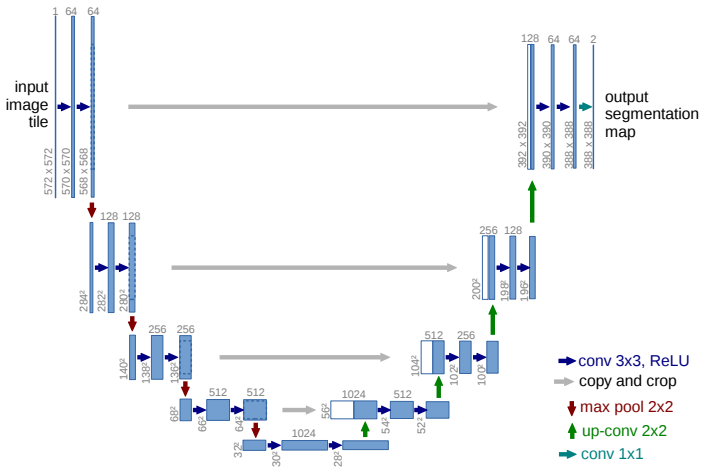

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [148]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.decoder4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))
        e4 = self.encoder4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return self.final_conv(d1)


In [149]:
unet_model = UNet().to(device)

In [173]:
train_unet_1_losses, val_unet_1_losses = train(
    model=unet_model,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=nn.BCEWithLogitsLoss() ,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    save_path="best_unet.pth",
    epochs=30
)

Epoch 1/30 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s, val_loss=0.6804, iou=0.2936]


New best model saved with IoU: 0.3669


Epoch 2/30 [Val]: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s, val_loss=0.6690, iou=0.3735]


New best model saved with IoU: 0.3708


Epoch 7/30 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s, val_loss=0.6899, iou=0.3138]


New best model saved with IoU: 0.3710


Epoch 11/30 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s, val_loss=0.6854, iou=0.3284]


New best model saved with IoU: 0.3713


Epoch 13/30 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s, val_loss=0.6794, iou=0.3695]


New best model saved with IoU: 0.3714


Epoch 16/30 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s, val_loss=0.6563, iou=0.4109]


New best model saved with IoU: 0.3722


Epoch 17/30 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s, val_loss=0.6805, iou=0.3473]


New best model saved with IoU: 0.3722


Epoch 18/30 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s, val_loss=0.6586, iou=0.4066]


New best model saved with IoU: 0.3723


Epoch 22/30 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s, val_loss=0.6376, iou=0.4929]


New best model saved with IoU: 0.3728


Epoch 28/30 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s, val_loss=0.6901, iou=0.3268]


New best model saved with IoU: 0.3731


Epoch 30/30 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s, val_loss=0.6616, iou=0.4339]


In [157]:
train_unet_2_losses, val_unet_2_losses = train(
    model=unet_model,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=dice_loss ,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    save_path="best_unet.pth",
    epochs=20
)

Epoch 1/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s, val_loss=0.5954, iou=0.3670]


New best model saved with IoU: 0.3702


Epoch 7/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s, val_loss=0.5780, iou=0.4137]


New best model saved with IoU: 0.3704


Epoch 9/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s, val_loss=0.6127, iou=0.3439]


New best model saved with IoU: 0.3709


Epoch 12/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s, val_loss=0.6190, iou=0.3455]


New best model saved with IoU: 0.3711


Epoch 13/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s, val_loss=0.6012, iou=0.3895]


New best model saved with IoU: 0.3717


Epoch 16/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s, val_loss=0.5928, iou=0.3870]


New best model saved with IoU: 0.3721


Epoch 20/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s, val_loss=0.6392, iou=0.3225]


In [156]:
train_unet_3_losses, val_unet_3_losses = train(
    model=unet_model,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=focal_loss ,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    save_path="best_unet.pth",
    epochs=20
)

Epoch 1/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s, val_loss=440615.3750, iou=0.4066]


New best model saved with IoU: 0.3720


Epoch 3/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s, val_loss=429015.8750, iou=0.3579]


New best model saved with IoU: 0.3723


Epoch 17/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s, val_loss=439006.5938, iou=0.4399]


New best model saved with IoU: 0.3725


Epoch 20/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s, val_loss=402435.3125, iou=0.3410]


In [161]:
test1_loss, test1_iou = test(
    model=segnet_model,
    test_loader=test_dataloader,
    criterion=nn.BCEWithLogitsLoss(),
    device=device,
    save_path='segtest_predictions.pt'
)

Testing: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s, test_loss=0.3975, iou=0.7077]


Test Loss: 0.3843 | Test IoU: 0.7279
Predictions saved to segtest_predictions.pt


In [162]:
test2_loss, test2_iou = test(
    model=unet_model,
    test_loader=test_dataloader,
    criterion=nn.BCEWithLogitsLoss(),
    device=device,
    save_path='utest_predictions.pt'
)

Testing: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s, test_loss=0.6797, iou=0.3924]


Test Loss: 0.6772 | Test IoU: 0.3645
Predictions saved to utest_predictions.pt


In [163]:
seg_predictions = torch.load('segtest_predictions.pt')
unet_predictions = torch.load('utest_predictions.pt')

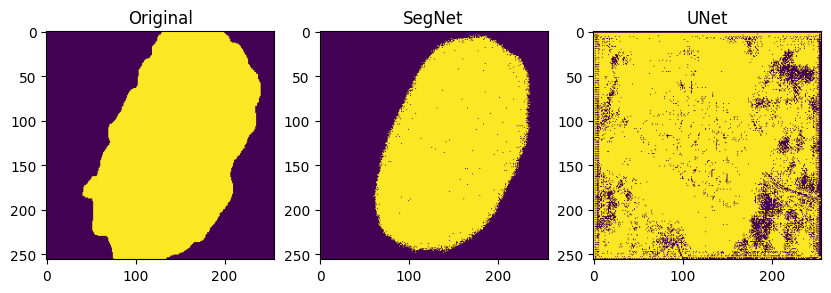

In [171]:
seg_images = seg_predictions['images']
seg_masks = seg_predictions['masks']
seg_preds = seg_predictions['preds']

unet_images = unet_predictions['images']
unet_masks = unet_predictions['masks']
unet_preds = unet_predictions['preds']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3*10))

ax1.imshow(seg_masks[0].squeeze(0).cpu())
ax1.set_title("Original")

ax2.imshow(seg_preds[0].squeeze(0).cpu())
ax2.set_title("SegNet")

ax3.imshow(unet_preds[0].squeeze(0).cpu())
ax3.set_title("UNet")

plt.show()

# ребят,отпишите че да как с unet делать) Как заставить его выводить хоть что то адекватное,пробовал и шаги и эпохи докидывать,все равно толку не особо много.Как на зло закончился доступ к граф процессору

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
Segnet показал значительно лучшие показатели по метрикам
*   Какая модель дает лучшие значения по лоссам?
Аналогично Segnet показал лучшие результаты на всех вариациях loss функций.Скорее всего роль играет нормализация батча,по сколько в те года именно его представили.
*   Какая модель обучается быстрее?
Segnet быстрее обучается,если сравнить по данным во время обучения
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.

